# Project: Classifying buildings post-Hurricane
Univ.AI <br>
AI-2 Cohort-4

:



### Names of the people who worked on the project: Hari Krishna, Rajasekhar, Pratik Ghute.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#RUN THIS CELL
import os
import pathlib

working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

In [ ]:

import os
import certifi
import urllib3  # For handling https certificate verification 
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
import scipy.ndimage as ndimage
import subprocess
from pathlib import Path
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import keras
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# # #unzipping zipped data file

# import zipfile
# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data','r')
# zip_ref.extractall('/content/drive/MyDrive/data')
# zip_ref.close()

In [ ]:
#assigning respective folder paths
train_damage_dir = '/content/drive/MyDrive/data/train_another/damage'
validation_damage_dir = '/content/drive/MyDrive/data/validation_another/damage'
test_damage_dir = '/content/drive/MyDrive/data/test/damage'
test_another_damage_dir = '/content/drive/MyDrive/data/test_another/damage'


train_nodamage_dir = '/content/drive/MyDrive/data/train_another/no_damage'
validation_nodamage_dir = '/content/drive/MyDrive/data/validation_another/no_damage'
test_nodamage_dir = '/content/drive/MyDrive/data/test/no_damage'
test_another_nodamage_dir = '/content/drive/MyDrive/data/test_another/no_damage'

In [ ]:
#Normalizing and using generator on train and validation sets as the number of data elements is large
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    '/content/drive/MyDrive/data/train_another', 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(
                    '/content/drive/MyDrive/data/validation_another',
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
#  using generator on test set as the number of data elements is large
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    '/content/drive/MyDrive/data/test_another',
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary',
)       

Found 9000 images belonging to 2 classes.


In [ ]:
#  using generator on test set Balanced one
test_gen = ImageDataGenerator(rescale=1./255)
test_data_balanced = test_gen.flow_from_directory(
    '/content/drive/MyDrive/data/test',
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary',
)    

Found 2000 images belonging to 2 classes.


In [ ]:
# function to print images and titles
titles = ['Damaged', 'No_Damaged']
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        plt.subplots_adjust(bottom=0., right=0.8, top=0.9)
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

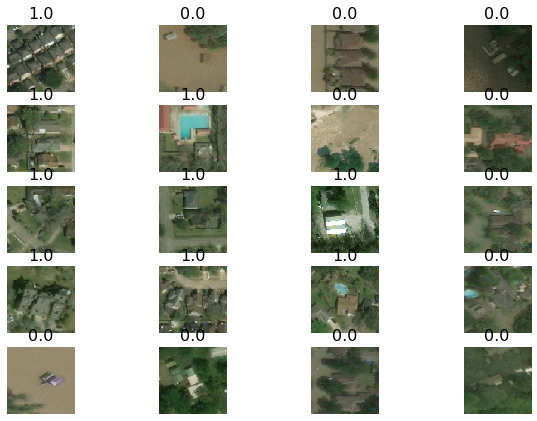

In [ ]:
#printing images with their titles 0 indicates damaged and 1 undamaged
imgs, labels = next(train_generator)
plots(imgs, titles=labels, rows = 5)

In [ ]:
import pandas as pd
from pathlib import Path


In [ ]:
# Creating a DataFrame of variables and images
input_path = '/content/drive/MyDrive/data'
image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x))

In [ ]:
# Having look at the DataFrame
image_df

,path,damage,data_split,location,lon,lat
0,/content/drive/MyDrive/data/test_another/damag...,damage,test_another,-95.66546_29.816244,-95.665460,29.816244
1,/content/drive/MyDrive/data/test_another/damag...,damage,test_another,-95.665503_29.833897999999998,-95.665503,29.833898
2,/content/drive/MyDrive/data/test_another/damag...,damage,test_another,-95.665514_29.831739000000002,-95.665514,29.831739
3,/content/drive/MyDrive/data/test_another/damag...,damage,test_another,-95.66551899999999_29.821733000000002,-95.665519,29.821733
4,/content/drive/MyDrive/data/test_another/damag...,damage,test_another,-95.665577_29.831982,-95.665577,29.831982
...,...,...,...,...,...,...
22995,/content/drive/MyDrive/data/test/no_damage/-96...,no_damage,test,-96.99940699999999_28.815549,-96.999407,28.815549
22996,/content/drive/MyDrive/data/test/no_damage/-96...,no_damage,test,-96.999534_28.765522999999998,-96.999534,28.765523
22997,/content/drive/MyDrive/data/test/no_damage/-97...,no_damage,test,-97.00007_28.823202000000002,-97.000070,28.823202
22998,/content/drive/MyDrive/data/test/no_damage/-97...,no_damage,test,-97.000443_28.859588000000002,-97.000443,28.859588


In [ ]:
# Assigning Data to respective variables
train = image_df[image_df['data_split']=='train_another']
test = image_df[image_df['data_split']=='test_another']
val = image_df[image_df['data_split']=='validation_another']

Text(0, 0.5, 'latitude')

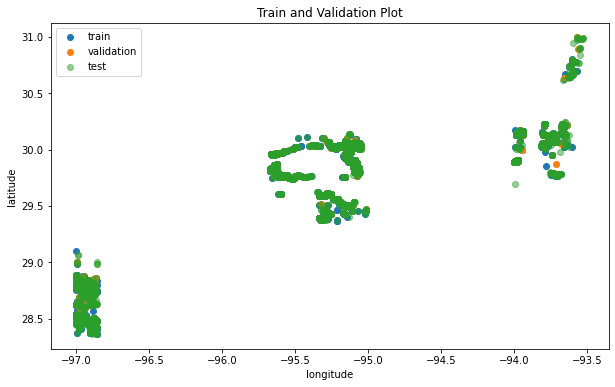

In [ ]:
# Plotting data sets train and validation test on latitude and longitude
fig, ax = plt.subplots( figsize=(10,6))
plt.scatter(train['lon'], train['lat'], label='train')
plt.scatter(val['lon'], val['lat'], label='validation')
plt.scatter(test['lon'], test['lat'], label='test', alpha=0.5)
plt.title('Train and Validation Plot')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')

In [ ]:
# assigning damaged and non damaged data to variables
image_dmg = image_df[image_df['damage']=='damage']
image_nodmg = image_df[image_df['damage']=='no_damage']
image_dmg.reset_index(drop=True,inplace=True)
image_nodmg.reset_index(drop=True,inplace=True)

In [ ]:
!pip install geopandas
import geopandas

fp = "/content/drive/MyDrive/data/shapes/tl_2016_48_cousub.shp"
data = geopandas.read_file(fp)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.4 MB/s 
     |████████████████████████████████| 16.6 MB 60.7 MB/s 
     |████████████████████████████████| 7.8 MB 54.0 MB/s 


In [ ]:
!pip install pyshp

import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader(fp)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 


<Figure size 432x288 with 0 Axes>

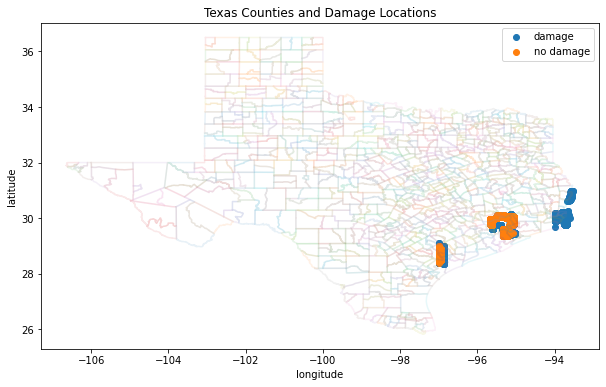

In [ ]:
# Plotting damaged and unadamaged locations  on texas country Map
plt.figure()
fig, ax = plt.subplots( figsize=(10,6))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, alpha = 0.1)
plt.scatter(image_dmg['lon'], image_dmg['lat'], color='C0',  label='damage')
plt.scatter(image_nodmg['lon'], image_nodmg['lat'], color='C1',  label='no damage')
plt.title('Texas Counties and Damage Locations')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

### Add to Project.ipynb

In [ ]:
# Loading Saved Model for operations
model_1 = load_model('/content/drive/MyDrive/data/models/model.h5')

In [ ]:
model = model_1
from keras import models
import random 

In [ ]:
# assigning input path of data
input_path = '/content/drive/MyDrive/data/train_another/'
train_files = list(Path(input_path).glob('**/*.jp*g'))


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array


In [ ]:
fil = random.choice(train_files)

In [ ]:
img = load_img(fil, target_size = (150,150))

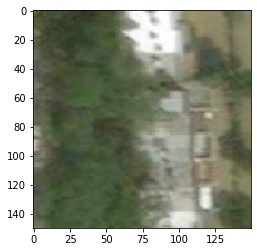

In [ ]:
# Creating Image tensors
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# creating plot dunction to plot images and labels further easily
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze() + 0.5)

    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',size=16,y=1.05);

In [ ]:
! pip install graphviz 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


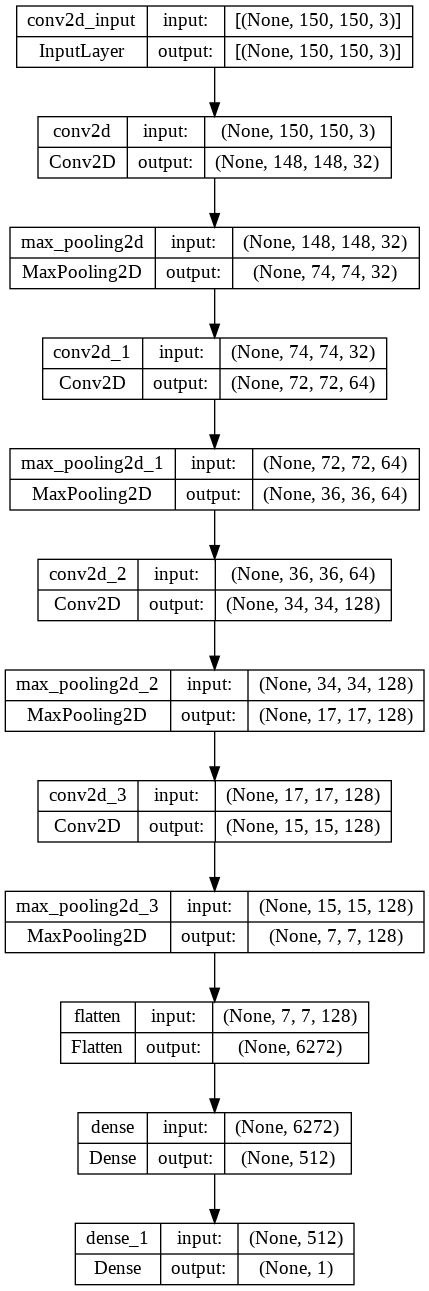

In [ ]:
# plotting Loaded model_1's structure
keras.utils.plot_model(
    model,
    show_shapes=True
)

1/1 [==============================] - 8s 8s/step


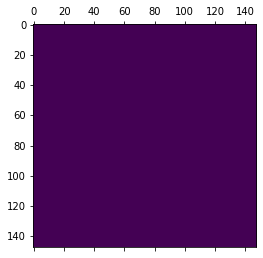

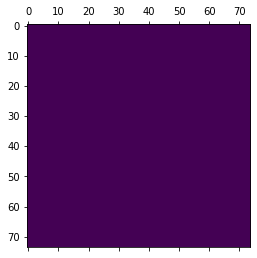

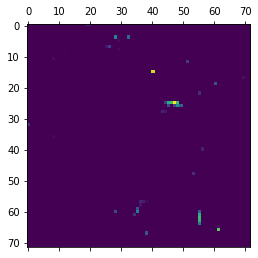

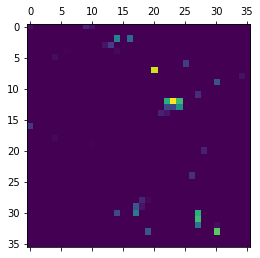

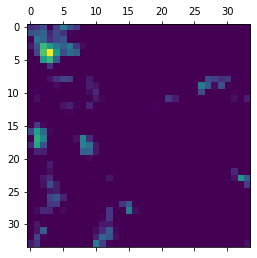

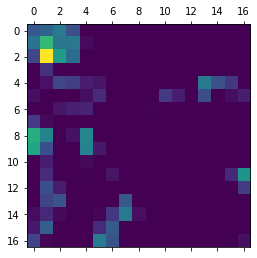

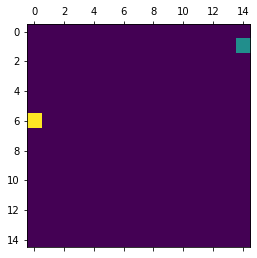

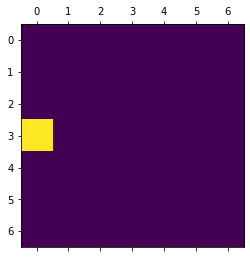

In [ ]:

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

#First Layer
activations = activation_model.predict(img_tensor)

# first_layer_activation = activations[0]
# plt.matshow(first_layer_activation[0,:,:,2],cmap = 'viridis')

for i in range(0,8):
    first_layer_activation = activations[i]
    plt.matshow(first_layer_activation[0,:,:,2],cmap = 'viridis')

In [ ]:
# Having Look at the Model_1's Prediction
predictions = model_1.predict_generator(test_data, steps=1, verbose=0)
print(predictions)

<ipython-input-33-0ce342d33651>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_1.predict_generator(test_data, steps=1, verbose=0)


[[3.0951492e-02]
 [3.8654162e-04]
 [1.8312004e-01]
 [1.7498240e-02]
 [3.0338787e-04]
 [9.9999011e-01]
 [1.7940780e-05]
 [7.1134061e-02]
 [1.4535312e-03]
 [9.9255415e-03]
 [1.6150714e-04]
 [6.4041160e-02]
 [7.6411232e-02]
 [6.4742770e-03]
 [1.1620199e-02]
 [3.2259084e-04]
 [1.4343537e-01]
 [1.8114405e-02]
 [9.9975055e-01]
 [8.6304244e-09]]


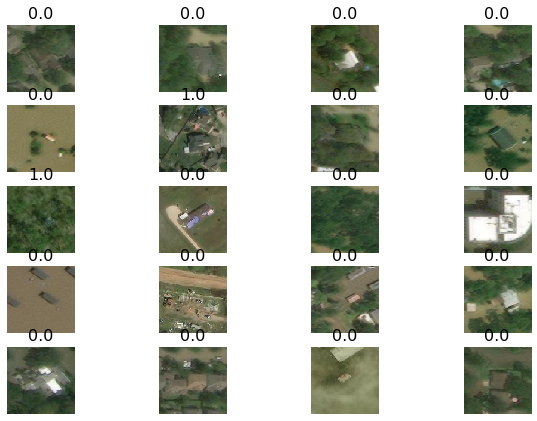

In [ ]:
# PLotting samples with Labels from Test Data
imgs, labels = next(test_data)
plots(imgs, titles=labels, rows = 5)

In [ ]:
# we need to create a convolutional neural netowrk to calssify a series of satellite images of cyclone damaged buildings into
# damged and non-damged. these are the only two classes we are interested in.
# use various strategies to improve the accuracy of the model, such as Adam, Drop out, Batch Normalization
# also use max pooling appropriately in the network
# the input shape of the images is 150x150x3
#creating first model

# CReating Model_2 one with Dropout

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary() 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
#compile the model, use the adam optimizer and binary cross entropy loss function
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 1e-4), metrics = ['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_mdo = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=20)

<ipython-input-37-66bd3d78f9eb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mdo = model.fit_generator(


Epoch 1/20
100/100 [==============================] - 601s 6s/step - loss: 0.6740 - acc: 0.5610 - val_loss: 0.6843 - val_acc: 0.4875
Epoch 2/20
100/100 [==============================] - 484s 5s/step - loss: 0.5675 - acc: 0.7160 - val_loss: 0.4606 - val_acc: 0.8025
Epoch 3/20
100/100 [==============================] - 387s 4s/step - loss: 0.4912 - acc: 0.7830 - val_loss: 0.4837 - val_acc: 0.7925
Epoch 4/20
100/100 [==============================] - 312s 3s/step - loss: 0.4623 - acc: 0.8090 - val_loss: 0.3853 - val_acc: 0.8550
Epoch 5/20
100/100 [==============================] - 239s 2s/step - loss: 0.4436 - acc: 0.8165 - val_loss: 0.3917 - val_acc: 0.8075
Epoch 6/20
100/100 [==============================] - 200s 2s/step - loss: 0.3751 - acc: 0.8535 - val_loss: 0.3151 - val_acc: 0.9025
Epoch 7/20
100/100 [==============================] - 154s 2s/step - loss: 0.3480 - acc: 0.8730 - val_loss: 0.2468 - val_acc: 0.9100
Epoch 8/20
100/100 [==============================] - 127s 1s/step - 

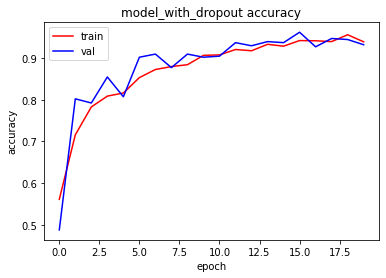

In [ ]:
# Plotting Dropout Models Train and validation accuracy
plt.plot(history_mdo.history['acc'],color='red',label='train')
plt.plot(history_mdo.history['val_acc'],color='blue',label='validation')
plt.title('model_with_dropout accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Saving instance of dropout Model
model.save('model_with_dropout.h5')

In [ ]:
# creating third model i.e. Alex Model
alex_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(150,150,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
alex_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

In [ ]:
# Setting call back for models best epoch including Early Stopping
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    restore_best_weights=True,
)

In [ ]:
# fitting alex model on train gen data and saving instance at summary_al
history_al = alex_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/100


<ipython-input-42-3f5b9dda03b5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_al = alex_model.fit_generator(


100/100 [==============================] - 17s 157ms/step - loss: 1.1255 - accuracy: 0.5105 - recall: 0.5975 - val_loss: 0.6960 - val_accuracy: 0.4980 - val_recall: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - loss: 0.8900 - accuracy: 0.5975 - recall: 0.6203 - val_loss: 0.7993 - val_accuracy: 0.5220 - val_recall: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 11s 106ms/step - loss: 0.7917 - accuracy: 0.6400 - recall: 0.6256 - val_loss: 1.1565 - val_accuracy: 0.4980 - val_recall: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 9s 89ms/step - loss: 0.7668 - accuracy: 0.6615 - recall: 0.6385 - val_loss: 1.3107 - val_accuracy: 0.4940 - val_recall: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 9s 90ms/step - loss: 0.6940 - accuracy: 0.7240 - recall: 0.7183 - val_loss: 1.2367 - val_accuracy: 0.5080 - val_recall: 0.0120
Epoch 6/100
100/100 [==============================] - 9s 87ms/step - loss: 0.70

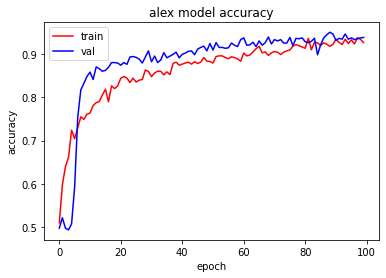

In [ ]:
# Plotting alex Model's train and validation Accuracy
plt.plot(history_al.history['accuracy'],color='red',label='train')
plt.plot(history_al.history['val_accuracy'],color='blue',label='validation')
plt.title('alex model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Saving alex_model
alex_model.save('alex.h5')

#**#Evaluating Models performance on test data Unbalnced**
 
---



In [ ]:
# Loading earlier saved Model_1
model_1 = load_model('/content/drive/MyDrive/data/models/model.h5')

In [ ]:
# evaluating model_1 Test Data Unbalnced 
loss_and_metrics_1un = model_1.evaluate_generator(test_data, steps=50)
print(model_1.metrics_names)
print("Test Loss", loss_and_metrics_1un[0])
print("Test Accuracy", loss_and_metrics_1un[1])

<ipython-input-22-b8a5e44b464d>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_1un = model_1.evaluate_generator(test_data, steps=50)


['loss', 'acc']
Test Loss 0.13055767118930817
Test Accuracy 0.9470000267028809


In [ ]:
# Earllier saved model_2 with dropout layers
model_2 = load_model('/content/drive/MyDrive/data/models/model_with_dropout.h5')

In [ ]:
# evaluating model_2 Test Data Unbalnced 

loss_and_metrics_2un = model_2.evaluate_generator(test_data, steps=50)
print("Test Loss", loss_and_metrics_2un[0])
print("Test Accuracy", loss_and_metrics_2un[1])

<ipython-input-24-9efeb0411915>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_2un = model_2.evaluate_generator(test_data, steps=50)


Test Loss 0.09379513561725616
Test Accuracy 0.968999981880188


In [ ]:
# # Earllier saved alex model 
model_3 = load_model('/content/drive/MyDrive/data/models/alex.h5')

In [ ]:
# # evaluating alex model Test Data Unbalnced 

loss_and_metrics_3un = model_3.evaluate_generator(test_data, steps=50)
print("Test Loss", loss_and_metrics_3un[0])
print("Test Accuracy", loss_and_metrics_3un[1])

<ipython-input-26-ff3953b29ef6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_3un = model_3.evaluate_generator(test_data, steps=50)


Test Loss 0.1383875161409378
Test Accuracy 0.9480000138282776


**transfer-learning-finetuning.**

In [ ]:
# Using VGG16 for classifcation Problem and finetuning as the data set for classification is not same as used for vgg16's training 
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3))

# conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

58889256/58889256 [==============================] - 3s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
# Summary of VGG16 model's Convolutional Layers
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Creating Model with Dense layers for vgg16
from keras import Sequential
model_v = Sequential()

model_v.add(conv_base)
model_v.add(Flatten())
model_v.add(Dense(256,activation='relu'))
model_v.add(Dense(1,activation='sigmoid'))

model_v.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# getiing model trained on train_generator data and saving history_v
history_v = model_v.fit(train_generator,epochs=20,validation_data=validation_generator)


Epoch 1/20
500/500 [==============================] - 318s 638ms/step - loss: 0.1385 - accuracy: 0.9438 - val_loss: 0.2020 - val_accuracy: 0.9190
Epoch 2/20
500/500 [==============================] - 49s 97ms/step - loss: 0.1026 - accuracy: 0.9595 - val_loss: 0.1208 - val_accuracy: 0.9535
Epoch 3/20
500/500 [==============================] - 47s 95ms/step - loss: 0.0763 - accuracy: 0.9700 - val_loss: 0.1114 - val_accuracy: 0.9585
Epoch 4/20
500/500 [==============================] - 48s 96ms/step - loss: 0.0555 - accuracy: 0.9803 - val_loss: 0.1311 - val_accuracy: 0.9570
Epoch 5/20
500/500 [==============================] - 51s 102ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.1316 - val_accuracy: 0.9590
Epoch 6/20
500/500 [==============================] - 47s 95ms/step - loss: 0.0297 - accuracy: 0.9897 - val_loss: 0.1155 - val_accuracy: 0.9705
Epoch 7/20
500/500 [==============================] - 48s 95ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 0.1272 - val_accura

In [ ]:
# Saving transfer Learned finetuned VGG16
model_v.save('finetuned_vgg16.h5')

In [ ]:
# Accessing transfer Learned finetuned VGG16
model_3 = load_model('/content/drive/MyDrive/data/models/finetuned_vgg16.h5')

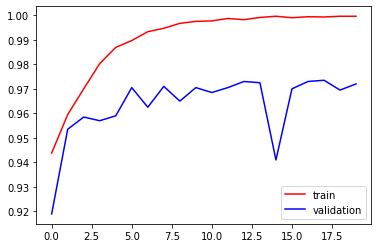

In [ ]:
# plotting training and validation accuracy of vgg16 model
plt.plot(history_v.history['accuracy'],color='red',label='train')
plt.plot(history_v.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

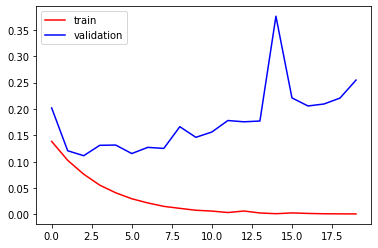

In [ ]:
# plotting training and validation loss of vgg16 model
plt.plot(history_v.history['loss'],color='red',label='train')
plt.plot(history_v.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
#Evaluating Vgg16 transfer-learning-finetuned model on Unbalanced Test set  
loss_and_metrics_vun = model_v.evaluate_generator(test_data, steps=50)
print("Test Loss", loss_and_metrics_vun[0])
print("Test Accuracy", loss_and_metrics_vun[1])

<ipython-input-36-91ea29f60d8e>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_vun = model_v.evaluate_generator(test_data, steps=50)


Test Loss 0.24749109148979187
Test Accuracy 0.9629999995231628


#**Evaluating Models on Balanced Data set to Compare Model Performance**


vgg16 finetuned

In [ ]:
loss_and_metrics_v = model_v.evaluate_generator(test_data_balanced, steps=50)
print("Test Loss", loss_and_metrics_v[0])
print("Test Accuracy", loss_and_metrics_v[1])

<ipython-input-37-5e9a3d584f55>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_v = model_v.evaluate_generator(test_data_balanced, steps=50)


Test Loss 0.1279793083667755
Test Accuracy 0.9810000061988831


costume model_1

In [ ]:
loss_and_metrics_1 = model_1.evaluate_generator(test_data_balanced, steps=50)
print("Test Loss", loss_and_metrics_1[0])
print("Test Accuracy", loss_and_metrics_1[1])

<ipython-input-38-15de6d3ef30c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_1 = model_1.evaluate_generator(test_data_balanced, steps=50)


Test Loss 0.10294630378484726
Test Accuracy 0.9570000171661377


costume model_2 with dropout layer

In [ ]:
loss_and_metrics_2 = model_2.evaluate_generator(test_data_balanced, steps=50)
print("Test Loss", loss_and_metrics_2[0])
print("Test Accuracy", loss_and_metrics_2[1])

<ipython-input-39-fa2318954811>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_2 = model_2.evaluate_generator(test_data_balanced, steps=50)


Test Loss 0.08783604204654694
Test Accuracy 0.9649999737739563


costume model_3 referring to structure of SOTA Alex Model

In [ ]:
loss_and_metrics_3 = model_3.evaluate_generator(test_data_balanced, steps=50)
print("Test Loss", loss_and_metrics_3[0])
print("Test Accuracy", loss_and_metrics_3[1])

<ipython-input-40-88cc041c692a>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_and_metrics_3 = model_3.evaluate_generator(test_data_balanced, steps=50)


Test Loss 0.19084100425243378
Test Accuracy 0.9779999852180481


In [ ]:
# Load the validation loss and accuracy for the four models
model1_loss = loss_and_metrics_v[0]*100
model1_acc = loss_and_metrics_v[1]*100
model2_loss = loss_and_metrics_1[0]*100
model2_acc = loss_and_metrics_1[1]*100
model3_loss = loss_and_metrics_2[0]*100
model3_acc = loss_and_metrics_2[1]*100
model4_loss = loss_and_metrics_3[0]*100
model4_acc = loss_and_metrics_3[1]*100


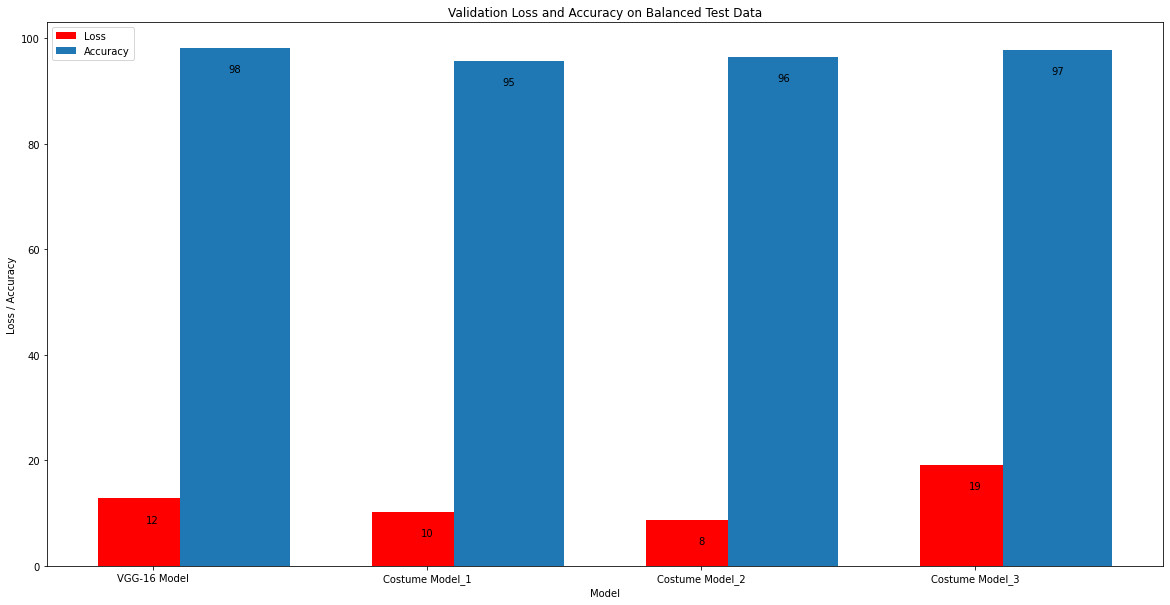

In [ ]:
# Create the figure and subplots
fig, ax = plt.subplots(figsize=(20, 10))

# Set the positions of the models on the x-axis
x_loss = [1, 2, 3, 4]
x_acc = [1.3, 2.3, 3.3, 4.3]

# Plot the validation loss for the four models as bars
ax.bar(x_loss, [model1_loss, model2_loss, model3_loss, model4_loss], width, label='Loss', color='r')

# Plot the validation accuracy for the four models as bars
ax.bar(x_acc, [model1_acc, model2_acc, model3_acc, model4_acc], width, label='Accuracy')

# Set the x-axis labels
ax.set_title('Validation Loss and Accuracy on Balanced Test Data')
ax.set_xlabel('Model')
ax.set_ylabel('Loss / Accuracy')
ax.set_xticks(x_loss)
ax.set_xticklabels(['VGG-16 Model', 'Costume Model_1', 'Costume Model_2', 'Costume Model_3'])
ax.legend()

# Add the value of each bar to the bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height - 5,
            '%d' % int(height),
            ha='center', va='bottom')

# Show the plot
plt.show()

# **Conclusion:**

**1) From Texas Counties and Damage Locations plot we can infer that majority of Distruction happened in Location Ranging From Longitude -95 to -97 and latitude 28 to 30.**




**2) Irrespictive of Base model "Sigmoid" is the perfect activation function for Final layer with 1 Node as we have Binary Class to predict.**



**3) AS you can see Due to Transfer Learning, model's training time drastically reduced. Hence the VGG-16 Model Performed the best which proved itself lowest Computationally expensive and give Great Accuracy and lowest loss with very less number of epochs than other models.(at Second epoch only we got accuracy more than 95%)**



**4) All models gave us validation accuracy around 95% that indicates Classification is succesfull having low resolution images in dataset.**